In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, multivariate_normal

<h1 align="center"><b><u>Lecture 6 - Markov Chain Monte Carlo (MCMC)</u></b></h1>

<h2>Gibbs Sampler</h2>

In lecture 6, it has been shown how a joint distribution can be split into its conditionals, and the gibbs sampler implemented to take samples from the conditional distributions, forming a Markov chain - with  invariant distribution as the target joint distribution.

In this example, a bivariate Gaussian distribution is used as the target distribution.  Exact conditionals for the elements of the bivariate distibution are available, so the Gibbs sampler can be used.  Using the target distribution from the lecture notes:

$$
\pi(\mathbf{x}) = \mathcal{N} ( \mathbf{0}, \mathbf{C}  )
\text{   where, }
\mathbf{x} = 
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
\text{   and, }
\mathbf{C} = 
\begin{bmatrix}
1 & \rho\\
\rho & 1
\end{bmatrix}
$$

In [2]:
target = multivariate_normal(mean=[0,0], cov=[[1,0.5],[0.5,1]])       # Define the target distribution with rho = 0.5

The parameter $|\rho| \lt 1$, controls the degree of correllation between $x_1$ and $x_2$.  We will see how this impacts the basic Gibbs sampler in this example.

The exact conditional distribution for this Gaussian can be found analytically.  Attempt this yourself - write out the equation for the bivariate Gaussian $\pi(\mathbf{x}) = p(x_1, x_2)$ and rewrite for a fixed $x_2$ to give the conditional $p(x_1|x_2)$ (hint: expand the matrix equation in exponential then complete the square).  This gives:

$$
p(x_1|x_2) = \mathcal{N} (\rho x_2, 1-\rho^2)
$$

For the Gibbs sampler, we need the conditional distributions $p(y_1|x_2)$ and $p(y_2|y_1)$ which in this case is simply:

$$
y_1|x_2 \sim \mathcal{N} (\rho x_2, 1-\rho^2)\\
y_2|y_1 \sim \mathcal{N} (\rho y_1, 1-\rho^2)
$$

As shown in the lecture notes (Slide 5), because we are sampling from exact conditionals, the acceptance ratio is 1, meaning samples from the target distribution are taken simply by sampling from the conditionals, first $p(y_1|x_2)$ then $p(y_2|y_1)$.  The basic Gibbs sampler for this example is shown below.

In [3]:
def gibbs(initial, rho, N):
    
    samples = []

    x2 = initial[1]

    for _ in range(N):

        # generate first sample based on first conditional y1|x2
        y1 = norm.rvs(loc=rho*x2, scale=np.sqrt( 1-pow(rho,2) ) )

        # second sample based on y2|y1
        y2 = norm.rvs(loc=rho*y1, scale=np.sqrt( 1-pow(rho,2) ) )

        # add bivariate sample
        samples.append([y1,y2])

        # move on to next sample
        x2 = y2

    return np.array(samples)

In [4]:
###--- Parameters ---###
initial = [2,2]
p = 0.5
n = 10000

Gibbs samples are now taken, and plotted on a 2D histogram, and compared to the contours of the target pdf.

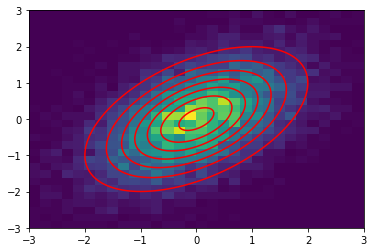

In [5]:
samples = gibbs(initial, p, n)

## Plotting
plt.hist2d(samples[:,0],samples[:,1], bins=30, range=([-3,3],[-3,3])) 
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
plt.contour(x, y, target.pdf(pos), colors='r')
plt.show()

We can now see the problems the gibbs sampler has, comparing samples for two different targets, one with low covariance, and one with high covariance.

In [6]:
n = 200

p_low = 0.5
p_high = 0.995

target_low = multivariate_normal(mean=[0,0], cov=[[1,p_low],[p_low,1]])
target_high = multivariate_normal(mean=[0,0], cov=[[1,p_high],[p_high,1]])

In [7]:
samples_low = gibbs(initial, p_low, n)
samples_high = gibbs(initial, p_high, n)

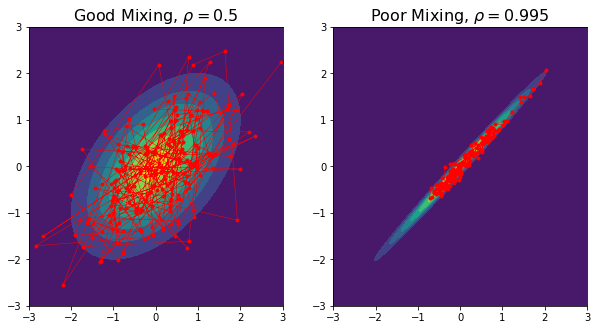

In [8]:
## Plotting
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5))
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
ax1.contourf(x, y, target_low.pdf(pos))
ax2.contourf(x, y, target_high.pdf(pos))
ax1.set_title("Good Mixing, $\\rho = {}$".format(p_low),fontsize=16)
ax2.set_title("Poor Mixing, $\\rho = {}$".format(p_high),fontsize=16)
plt.subplots_adjust(left=0.125,bottom=0.125,right=0.9,top=0.9,wspace=0.2,hspace=0.2)
ax1.plot(samples_low[:, 0], samples_low[:, 1], color='r', linestyle='-', marker='o', linewidth=0.5, markersize=3)
ax2.plot(samples_high[:, 0], samples_high[:, 1], color='r', linestyle='-', marker='o', linewidth=0.5, markersize=3)
ax1.set_xlim(-3,3)
ax1.set_ylim(-3,3)
ax2.set_xlim(-3,3)
ax2.set_ylim(-3,3)
plt.show()

The target with large covariance between the two dimensions is poorly represented by the samples for low $N$.  The step size in this case is very small, which can be seen mathematically by the variance of the two conditional distributions:  $\sigma^2 = 1-\rho^2$ which for $\rho$ close to 1 is very small.  The small step size leads to poor mixing which can be seen above.  The MH sampler would work better in this highly correllated example, provided the covariance of the proposal is similar to that of the target. 